In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utility import get_spotify_data, get_spotify_client
import spotipy as sp
import plotly.express as px

- Get all artists 
- Remove duplicates
- Call Spotify api to get related artists
- Remove the ones that aren't in my artists
- Connect each related artists to the base artist
- Show a graph/web graph

In [2]:
streaming_history = get_spotify_data('StreamingHistory')
streaming_history[:3]

[{'endTime': '2020-12-22 22:45',
  'artistName': 'meganeko',
  'trackName': 'Stasis',
  'msPlayed': 226000},
 {'endTime': '2020-12-22 22:59',
  'artistName': 'meganeko',
  'trackName': 'Robot Language',
  'msPlayed': 190008},
 {'endTime': '2020-12-22 23:05',
  'artistName': 'meganeko',
  'trackName': 'Robot Language',
  'msPlayed': 8435}]

In [3]:
df = pd.DataFrame.from_records(streaming_history)
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-12-22 22:45,meganeko,Stasis,226000
1,2020-12-22 22:59,meganeko,Robot Language,190008
2,2020-12-22 23:05,meganeko,Robot Language,8435
3,2020-12-22 23:06,meganeko,she speaks,57000
4,2020-12-22 23:10,meganeko,Super Gamer Girl 3D,289500


In [4]:
df.sort_values('endTime').head()

,endTime,artistName,trackName,msPlayed
67426,2019-12-16 00:21,Panic! At The Disco,Crazy = Genius,4940
67427,2020-03-07 18:13,Johann Sebastian Bach,"Bach, J.S.: Brandenburg Concerto No. 5 in D Ma...",31018
67428,2020-03-10 21:28,Austin Wintory,Temptations,236307
67429,2020-03-11 00:03,Ace Waters,Nihilist (feat. ThunderScott),88040
67430,2020-03-11 00:12,Ace Waters,Nihilist (feat. ThunderScott),3241


In [5]:
artist_df = df.groupby('artistName').sum('msPlayed')
artist_df['artist'] = artist_df.index
artist_df['hrsPlayed'] = artist_df['msPlayed'] / 60000 / 60
artist_df

,msPlayed,artist,hrsPlayed
artistName,,,
"""Weird Al"" Yankovic",57255270,"""Weird Al"" Yankovic",15.904242
10 Years,18156,10 Years,0.005043
100 gecs,0,100 gecs,0.000000
1000say,37,1000say,0.000010
11 Acorn Lane,11819316,11 Acorn Lane,3.283143
...,...,...,...
zabutom,1316335,zabutom,0.365649
zebrahead,12637,zebrahead,0.003510
zircon,3463824,zircon,0.962173


[Text(0.5, 0, 'Hours Played')]

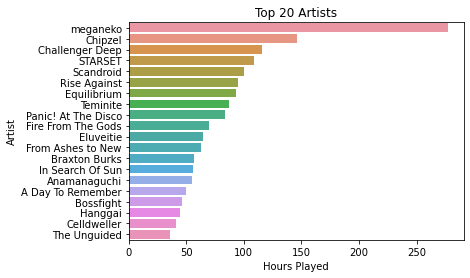

In [6]:
top_n_artists = 20
plotted_artist_df = artist_df.sort_values(by='hrsPlayed', ascending=False)[:top_n_artists]
ax = sns.barplot(data=plotted_artist_df, x='hrsPlayed', y='artist', orient='h')
ax.set(title=f'Top {top_n_artists} Artists')
ax.set(ylabel='Artist')
ax.set(xlabel='Hours Played')

In [7]:
%%capture
sp = get_spotify_client()

SpotifyOauthError: error: invalid_client, error_description: Invalid client

In [8]:
n_artists: int = 100
limited_artists = artist_df.sort_values(by='hrsPlayed', ascending=False)[:n_artists]
artists = [sp.search(q=artist, limit=1, type='artist')['artists']['items'][0] for artist in limited_artists['artist']]

AttributeError: module 'spotipy' has no attribute 'search'

In [ ]:
artists_big_df_raw = pd.DataFrame.from_records(artists, index='id', exclude=['external_urls', 'followers', 'href', 'images', 'type'])
artists_big_df_raw['id'] = artists_big_df_raw.index
artists_big_df = artists_big_df_raw.explode('genres').drop_duplicates()
artists_big_df.head()

In [ ]:
artists_big_df[artists_big_df['genres'].str.contains('rap', na=False)][['name','genres']].drop_duplicates()

In [ ]:
artists_big_df[['name','genres']].drop_duplicates('name').to_csv('./yeet.csv')

In [ ]:
artists_big_df['genres'].unique()

In [ ]:
genres_df = artists_big_df.groupby('genres').count().sort_values(by='id', ascending=False)
genres_df['genre'] = genres_df.index
genres_df.head()

In [ ]:
plotted_genres = genres_df[genres_df['id'] >= 5]
plotted_genres.shape

In [ ]:
ax = sns.barplot(data=plotted_genres, x='id', y='genre', orient='h')
ax.set(title='Genres with at least 5 artists')
ax.set(xlabel='# of Artists')
ax.set(ylabel='Genre')

In [ ]:
sns.barplot(data=genres_df[genres_df['id'] == 1][20:45], x='id', y='genre', orient='h')

In [ ]:
artists_big_df_raw.head()

In [ ]:
artist_df.head()

In [ ]:
artist_df.shape, artists_big_df_raw.shape

In [ ]:
values = {}
for artist_row in artists_big_df_raw.values:
    other_row = artist_df[artist_df['artist'] == artist_row[1]]
    values[artist_row[1]] = (artist_row, other_row)
pd.DataFrame.from_records(values).head()

In [ ]:
artists_joined_df = artists_big_df_raw.join(artist_df, on=['name', 'artist'])
# artists_big_df['hrsPlayed'] = [artist_df[artist_df['artist'] == artist]['hrsPlayed'] for artist in artists_big_df['name']]
artists_joined_df.head()